In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import pandas as pd

In [2]:


# Main genres
valid_genres = {
    "Action", "Adventure", "Animation", "Biography", "Comedy", "Documentary", "Drama", "Crime",
    "Family", "Fantasy", "Game-Show", "History", "Music", "Horror", "Musical", "Mystery",
    "Reality-TV", "Romance", "Short", "News", "Sci-Fi", "Sport", "Talk-Show",
    "War", "Thriller", "Western", "Film-Noir"
}

# Loading data
with open("data/films_data.json", "r", encoding="utf-8") as f:
    films = json.load(f)

# Filtering genres
for film in films:
    if "genres" in film:
        film["genres"] = list(set(film["genres"]) & valid_genres)

# Save
with open("data/films_data_cleaned.json", "w", encoding="utf-8") as f:
    json.dump(films, f, indent=2, ensure_ascii=False)

print("The file was successfully cleaned and saved as data/films_data_cleaned.json")


The file was successfully cleaned and saved as data/films_data_cleaned.json


In [3]:
# Load data from the original JSON
with open("data/films_data_cleaned.json", "r", encoding="utf-8") as file:
    films = json.load(file)

# Filter to remove movies with invalid values
def is_valid_film(film):
    required_fields = ["year", "countries", "num_of_awards", "num_of_nominations", "genres", "actors"]
    if any(film.get(field) in (None, [], "") for field in required_fields):
        return False
    if film.get("film_type") not in ("", "TV Movie"):
        return False
    return True

# We leave only valid films
valid_films = [film for film in films if is_valid_film(film)]

# We divide films into categories
all_known_films = [film for film in valid_films if None not in (film.get("imdb"), film.get("metascore"), film.get("production_budget"), film.get("box_office"))]
imdb_unknown = all_known_films + [film for film in valid_films if film.get("imdb") is None and film not in all_known_films and None not in (film.get("metascore"), film.get("production_budget"), film.get("box_office"))]
metascore_unknown = all_known_films + [film for film in valid_films if film.get("metascore") is None and film not in all_known_films and None not in (film.get("imdb"), film.get("production_budget"), film.get("box_office"))]
budget_unknown = all_known_films + [film for film in valid_films if film.get("production_budget") is None and film not in all_known_films and None not in (film.get("imdb"), film.get("metascore"), film.get("box_office"))]
box_office_unknown = all_known_films + [film for film in valid_films if film.get("box_office") is None and film not in all_known_films and None not in (film.get("imdb"), film.get("metascore"), film.get("production_budget"))]

# Function for writing data to JSON
def save_json(filename, data):
    with open(filename, "w", encoding="utf-8") as file:
        json.dump(data, file, indent=4, ensure_ascii=False)

# Write files
save_json("data/films_all_known.json", all_known_films)
save_json("data/films_imdb_unknown.json", imdb_unknown)
save_json("data/films_metascore_unknown.json", metascore_unknown)
save_json("data/films_budget_unknown.json", budget_unknown)
save_json("data/films_box_office_unknown.json", box_office_unknown)

print("Movies successfully filtered and saved into files.")

Movies successfully filtered and saved into files.


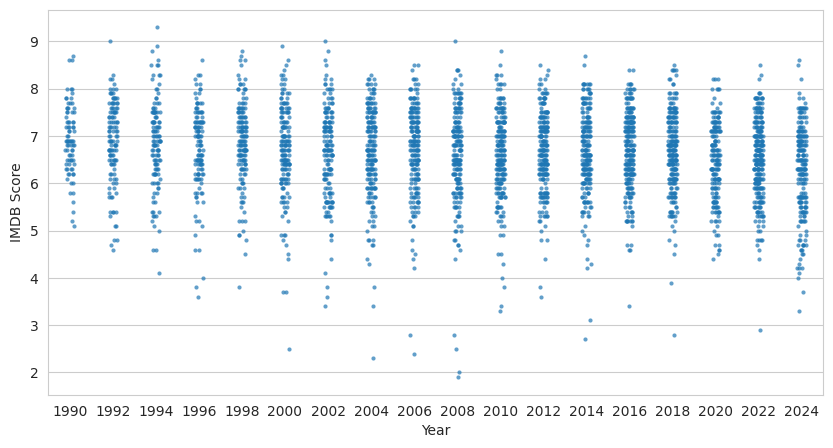

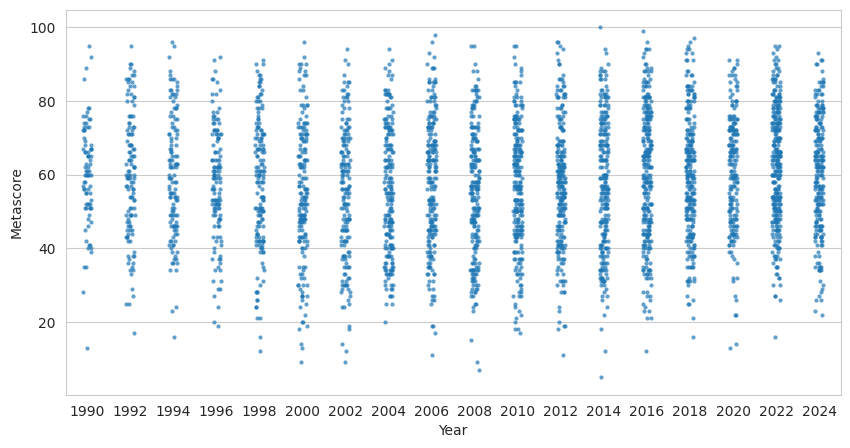

In [4]:
with open("data/films_budget_unknown.json", "r", encoding="utf-8") as f:
    films = json.load(f)

years = []
imdb_scores = []
metascores = []

for film in films:
    years.append(film["year"]//2*2)
    imdb_scores.append(film["imdb"])
    metascores.append(film["metascore"])

sns.set_style("whitegrid")

# Graph 1: Impact of release year on imdb
plt.figure(figsize=(10, 5))
sns.stripplot(x=years, y=imdb_scores, jitter=True, size=3, alpha=0.7)
plt.xlabel("Year")
plt.ylabel("IMDB Score")
plt.show()

# Graph 2: Impact of release year on metascore
plt.figure(figsize=(10, 5))
sns.stripplot(x=years, y=metascores, jitter=True, size=3, alpha=0.7)
plt.xlabel("Year")
plt.ylabel("Metascore")
plt.show()


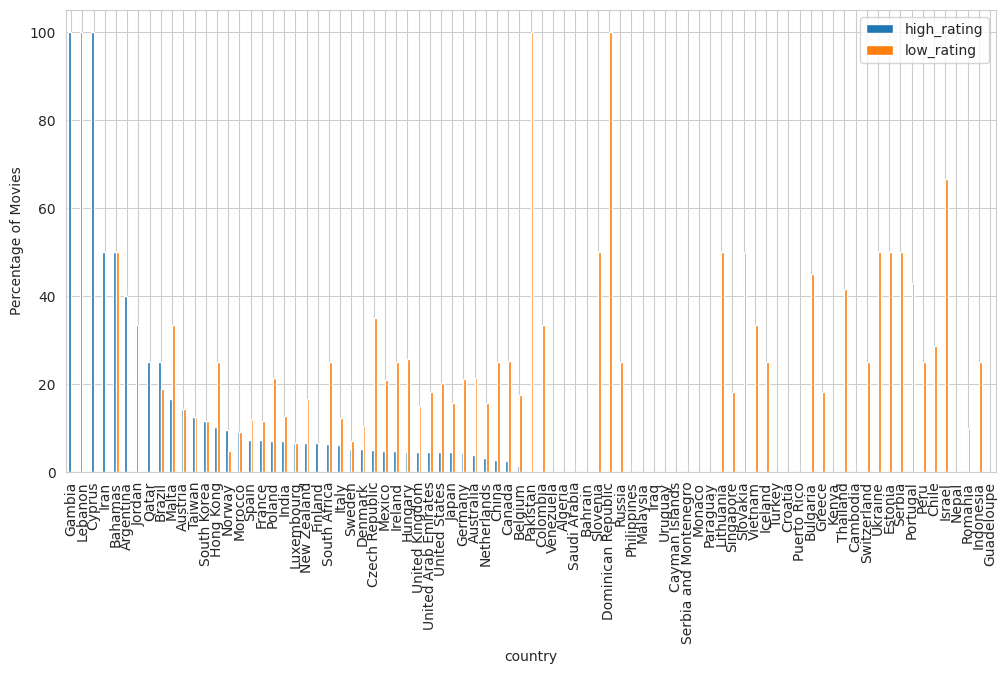

In [5]:
# Grouping data by countries
country_scores = defaultdict(lambda: {"high": 0, "low": 0, "total": 0})

for film in films:
    for country in film["countries"]:
        if int(film["imdb"]) > 7.2:
            country_scores[country]["high"] += 1
        elif int(film["imdb"]) < 6:
            country_scores[country]["low"] += 1
        country_scores[country]["total"] += 1

df = pd.DataFrame([
    {"country": country,
     "high_rating": (data["high"] / data["total"]) * 100,
     "low_rating": (data["low"] / data["total"]) * 100}
    for country, data in country_scores.items()
])

df = df.sort_values("high_rating", ascending=False)
df.set_index("country").plot(kind="bar", figsize=(12, 6))
plt.ylabel("Percentage of Movies")
plt.show()


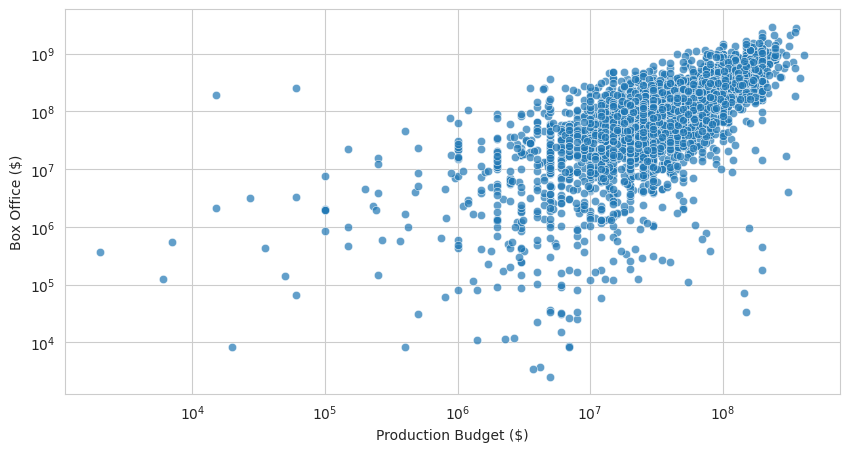

In [6]:
with open("data/films_metascore_unknown.json", "r", encoding="utf-8") as f:
    films = json.load(f)

budgets = []
box_offices = []

for film in films:
    if film["production_budget"] and film["box_office"]:
        budgets.append(film["production_budget"])
        box_offices.append(film["box_office"])

plt.figure(figsize=(10, 5))
sns.scatterplot(x=budgets, y=box_offices, alpha=0.7)
plt.xlabel("Production Budget ($)")
plt.ylabel("Box Office ($)")
plt.xscale("log")  # Use scale for better display
plt.yscale("log")
plt.show()


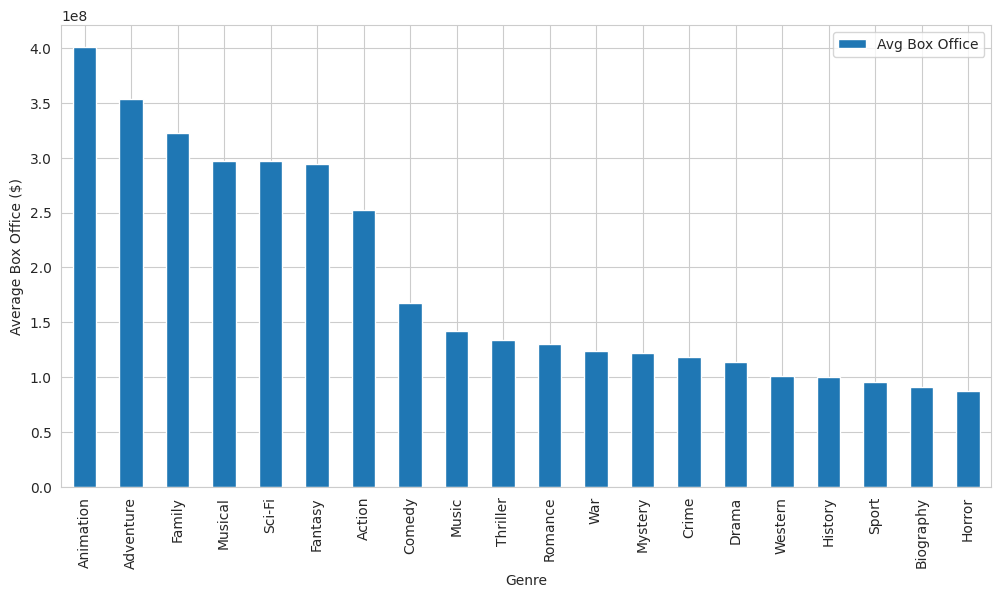

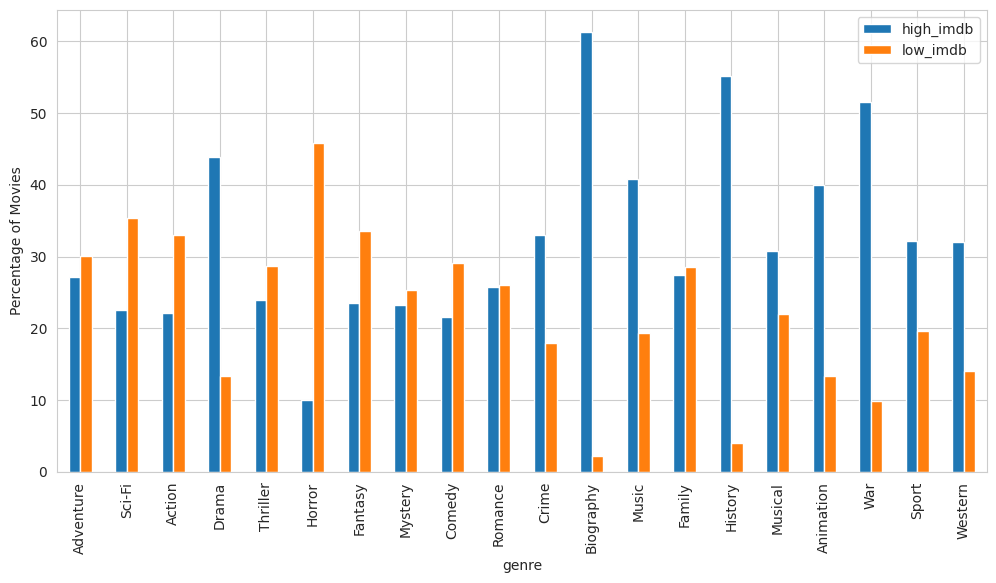

In [12]:
# Grouping by genres
genre_revenue = defaultdict(list)
genre_imdb = defaultdict(lambda: {"high": 0, "low": 0, "total": 0})

for film in films:
    for genre in film["genres"]:
        if film["box_office"]:
            genre_revenue[genre].append(film["box_office"])
        if film["imdb"] > 7.1:
            genre_imdb[genre]["high"] += 1
        elif film["imdb"] < 6.2:
            genre_imdb[genre]["low"] += 1
        genre_imdb[genre]["total"] += 1

# Average box office receipts
avg_revenue = {genre: np.mean(revenue) for genre, revenue in genre_revenue.items()}
df_revenue = pd.DataFrame(list(avg_revenue.items()), columns=["Genre", "Avg Box Office"])
df_revenue = df_revenue.sort_values("Avg Box Office", ascending=False)

# Graph 1: Average box office receipts by genre
df_revenue.set_index("Genre").plot(kind="bar", figsize=(12, 6))
plt.ylabel("Average Box Office ($)")
plt.show()

# Percentage of movies with high/low imdb
df_imdb = pd.DataFrame([
    {"genre": genre,
     "high_imdb": (data["high"] / data["total"]) * 100,
     "low_imdb": (data["low"] / data["total"]) * 100}
    for genre, data in genre_imdb.items()
])

# Chart 2: Double Bar Chart with high/low imdb
df_imdb.set_index("genre").plot(kind="bar", figsize=(12, 6))
plt.ylabel("Percentage of Movies")
plt.show()


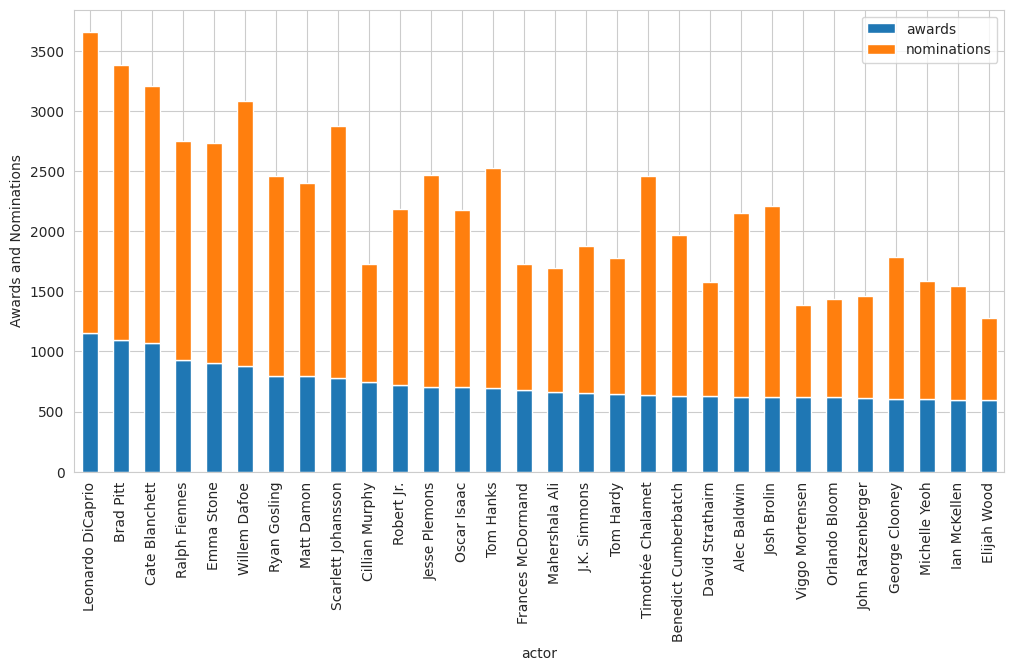

In [13]:
actor_awards = defaultdict(lambda: {"awards": 0, "nominations": 0})

for film in films:
    for actor in film["actors"]:
        actor_awards[actor["name"] + " " + actor["surname"]]["awards"] += film["num_of_awards"]
        actor_awards[actor["name"] + " " + actor["surname"]]["nominations"] += film["num_of_nominations"]

df_actors = pd.DataFrame([
    {"actor": actor, "awards": data["awards"], "nominations": data["nominations"]}
    for actor, data in actor_awards.items()
])



# Take the top 30 actors
df_actors = df_actors.sort_values("awards", ascending=False).head(30)
df_actors_low = df_actors.sort_values("awards", ascending=True).head(30)

df_actors.set_index("actor").plot(kind="bar", stacked=True, figsize=(12, 6))
plt.ylabel("Awards and Nominations")
plt.show()
